In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/collab_sandbox/becoder_2021/
!ls

Mounted at /content/drive
/content/drive/MyDrive/collab_sandbox/becoder_2021
'=0.24.0'				     catboost_info
 automl_regression_powerplant_output.ipynb   original_data.csv
 becoder_2021_EVRAZ.ipynb		     original_data.gsheet
 becoder_2021_EVRAZ_part_1_fixed.ipynb	     tmp
 becoder_2021_EVRAZ_part_2_final.ipynb


In [3]:
!pip install pytorch-tabnet

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn.apionly as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
# metrics
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error#, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import xgboost as xgb
# import catboost
import lightgbm as lgb

from scipy import stats
import numpy as np

from sklearn.model_selection import KFold
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import QuantileTransformer
from sklearn.utils.validation import check_array

def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()


# Look at data

In [7]:
dataset = pd.read_csv("original_data.csv", encoding='utf-8', sep=";")
null_values = dataset.isna().sum().sum()
dataset = dataset.drop(['Unnamed: 0', 'nplv', 'ПРОФИЛЬ', 'DT'], axis=1)
dataset

,МАРКА,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,...,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,Э76ХФ,"29,0","45,3666667","24,4","41,0333333",NaN,"0,45646","0,059572","0,117446","0,104762","0,0409383","1557,0","1580,0","13,6067425",NaN,"12809,0163934","115,5","1,0","1,0","1,0","18,611",NaN,NaN,NaN,NaN,"0,17",NaN,"0,401","0,123","0,02",NaN,NaN,NaN,"0,051939","0,112",NaN,"0,182",NaN,"0,106","5209,0",...,"0,389","0,368","0,127","0,682","0,01","0,011","0,086","0,009","0,023","0,459","0,002","0,002","0,003","0,756","0,0001","0,417","0,126","0,779","0,009","0,012","0,086","0,011","0,018","0,559","0,003","0,037",NaN,"63,7","1,1","3,7","0,12","2,6",NaN,NaN,"53,4","1,0","5,8","0,15","2,6",NaN
1,Э76ХФ,"26,0","44,0666667","13,8666667","44,0666667",NaN,"0,359285","0,083738","0,160923","0,110327","0,0400831","1601,0","1591,0","8,074721",NaN,"12816,3461538","111,6","1,0","1,0","1,0","11,659",NaN,NaN,NaN,NaN,"0,488",NaN,NaN,"0,094","0,02",NaN,NaN,NaN,"0,050854","0,102",NaN,"0,251",NaN,"0,149","2962,0",...,"0,465","0,345","0,112","0,643","0,009","0,011","0,08","0,007","0,023","0,461","0,002","0,002","0,003","0,774","0,0003","0,416","0,109","0,767","0,008","0,013","0,079","0,008","0,021","0,543","0,003","0,038",NaN,"58,5","0,8","4,9","0,14","2,2",NaN,NaN,"59,3","0,6","4,1","0,11","2,3",NaN
2,Э76ХФ,"24,0","43,35","17,95","43,35",NaN,"0,331665","0,08149","0,132332","0,13986","0,0416225","1593,0","1586,0","13,801968",NaN,"12511,4206128","115,8","1,0","1,0","1,0","19,871",NaN,NaN,NaN,NaN,"0,05",NaN,"0,346","0,061","0,02",NaN,NaN,NaN,"0,052807","0,16",NaN,"0,204",NaN,"0,145","3743,0",...,"0,513","0,351","0,107","0,674","0,007","0,011","0,078","0,008","0,019","0,455","0,002","0,002","0,004","0,77","0,0009","0,417","0,108","0,788","0,006","0,012","0,078","0,008","0,013","0,568","0,003","0,038",NaN,"58,0","0,8","8,6","0,12","2,6",NaN,NaN,"57,2","0,5","8,1","0,13","2,3",NaN
3,Э76ХФ,"17,0","46,1833333","19,8166667","46,1833333",NaN,"0,377945","0,133194","0,221605","0,165186","0,0420497","1589,0","1589,0","12,6649585",NaN,"12998,1497056","116,3","1,0","1,0","1,0","19,497",NaN,NaN,"0,077",NaN,"0,05",NaN,"0,39","0,059","0,02",NaN,NaN,NaN,"0,053349","0,161",NaN,"0,345",NaN,"0,237","4293,0",...,"0,487","0,31","0,105","0,611","0,009","0,011","0,07","0,006","0,02","0,434","0,001","0,001","0,003","0,767","0,0002","0,419","0,103","0,795","0,008","0,013","0,07","0,007","0,014","0,571","0,003","0,038",NaN,"59,8","0,4","6,4","0,11","2,4",NaN,NaN,"60,3","0,5","6,3","0,12","2,6",NaN
4,Э76ХФ,"20,0","48,5","17,0333333","48,5",NaN,"0,389875","0,105094","0,169459","0,143024","0,0409

In [8]:
null_values

119806

In [9]:
search_column = 'МАРКА'
most_popular_mark = dataset[search_column].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True).index[0]
most_popular_mark

'Э76ХФ'

In [10]:
missed_values_stat = dataset[dataset[search_column] == most_popular_mark].isna().sum()
dataset_mark = dataset[dataset[search_column] == most_popular_mark].drop([search_column], axis=1).fillna(0)
dataset_mark.head(3)

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,"29,0","45,3666667","24,4","41,0333333",0,"0,45646","0,059572","0,117446","0,104762","0,0409383","1557,0","1580,0","13,6067425",0,"12809,0163934","115,5","1,0","1,0","1,0","18,611",0,0,0,0,"0,17",0,"0,401","0,123","0,02",0,0,0,"0,051939","0,112",0,"0,182",0,"0,106","5209,0","0,002","0,389","0,368","0,127","0,682","0,01","0,011","0,086","0,009","0,023","0,459","0,002","0,002","0,003","0,756","0,0001","0,417","0,126","0,779","0,009","0,012","0,086","0,011","0,018","0,559","0,003","0,037",0,"63,7","1,1","3,7","0,12","2,6",0,0,"53,4","1,0","5,8","0,15","2,6",0
1,"26,0","44,0666667","13,8666667","44,0666667",0,"0,359285","0,083738","0,160923","0,110327","0,0400831","1601,0","1591,0","8,074721",0,"12816,3461538","111,6","1,0","1,0","1,0","11,659",0,0,0,0,"0,488",0,0,"0,094","0,02",0,0,0,"0,050854","0,102",0,"0,251",0,"0,149","2962,0","0,002","0,465","0,345","0,112","0,643","0,009","0,011","0,08","0,007","0,023","0,461","0,002","0,002","0,003","0,774","0,0003","0,416","0,109","0,767","0,008","0,013","0,079","0,008","0,021","0,543","0,003","0,038",0,"58,5","0,8","4,9","0,14","2,2",0,0,"59,3","0,6","4,1","0,11","2,3",0
2,"24,0","43,35","17,95","43,35",0,"0,331665","0,08149","0,132332","0,13986","0,0416225","1593,0","1586,0","13,801968",0,"12511,4206128","115,8","1,0","1,0","1,0","19,871",0,0,0,0,"0,05",0,"0,346","0,061","0,02",0,0,0,"0,052807","0,16",0,"0,204",0,"0,145","3743,0","0,002","0,513","0,351","0,107","0,674","0,007","0,011","0,078","0,008","0,019","0,455","0,002","0,002","0,004","0,77","0,0009","0,417","0,108","0,788","0,006","0,012","0,078","0,008","0,013","0,568","0,003","0,038",0,"58,0","0,8","8,6","0,12","2,6",0,0,"57,2","0,5","8,1","0,13","2,3",0


In [11]:
missed_values_mark = missed_values_stat.sum()

In [12]:
dataset_columns = list(dataset_mark.columns) 
dataset_mark = dataset_mark.astype(str)
for col in dataset_columns:
  dataset_mark[col] = dataset_mark[col].str.replace(",", ".").astype(float) 

In [13]:
dataset_mark.head()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,29.0,45.366667,24.400000,41.033333,0.0,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,1580.0,13.606742,0.0,12809.016393,115.5,1.0,1.0,1.0,18.611,0.0,0.0,0.000,0.0,0.170,0.0,0.401,0.123,0.02,0.0,0.0,0.0,0.051939,0.112,0.0,0.182,0.0,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,0.0,63.7,1.1,3.7,0.12,2.6,0.0,0.0,53.4,1.0,5.8,0.15,2.6,0.0
1,26.0,44.066667,13.866667,44.066667,0.0,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,1591.0,8.074721,0.0,12816.346154,111.6,1.0,1.0,1.0,11.659,0.0,0.0,0.000,0.0,0.488,0.0,0.000,0.094,0.02,0.0,0.0,0.0,0.050854,0.102,0.0,0.251,0.0,0.149,2962.0,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,0.0,58.5,0.8,4.9,0.14,2.2,0.0,0.0,59.3,0.6,4.1,0.11,2.3,0.0
2,24.0,43.350000,17.950000,43.350000,0.0,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,1586.0,13.801968,0.0,12511.420613,115.8,1.0,1.0,1.0,19.871,0.0,0.0,0.000,0.0,0.050,0.0,0.346,0.061,0.02,0.0,0.0,0.0,0.052807,0.160,0.0,0.204,0.0,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,0.0,58.0,0.8,8.6,0.12,2.6,0.0,0.0,57.2,0.5,8.1,0.13,2.3,0.0
3,17.0,46.183333,19.816667,46.183333,0.0,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,1589.0,12.664958,0.0,12998.149706,116.3,1.0,1.0,1.0,19.497,0.0,0.0,0.077,0.0,0.050,0.0,0.390,0.059,0.02,0.0,0.0,0.0,0.053349,0.161,0.0,0.345,0.0,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,0.0,59.8,0.4,6.4,0.11,2.4,0.0,0.0,60.3,0.5,6.3,0.12,2.6,0.0
4,20.0,48.500000,17.033333,48.500000,0.0,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,1592.0,10.298350,0.0,12987.475538,115.0,1.0,1.0,1.0,16.649,0.0,0.0,0.082,0.0,0.050,0.0,0.412,0.035,0.02,0.0,0.0,0.0,0.051975,0.149,0.0,0.263,0.0,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,0.0,59.6,0.7,4.7,0.12,2.4,0.0,0.0,60.3,0.6,4.5,0.09,2.5,0.0


# Delete future

In [14]:
target_col_1 = "химшлак последний Al2O3"
target_col_2 = "химшлак последний CaO"
target_col_3 = "химшлак последний R"
target_col_4 = "химшлак последний SiO2"

PREDICTIONS_ARRAY = {}
PREDICTIONS_ARRAY[target_col_1] = []
PREDICTIONS_ARRAY[target_col_2] = []
PREDICTIONS_ARRAY[target_col_3] = []
PREDICTIONS_ARRAY[target_col_4] = []

target_columns = [target_col_1, target_col_2, target_col_3, target_col_4]

def print_missed(column, missed_values_stat=missed_values_stat, total=len(dataset_mark)):
  missed_count = missed_values_stat[column]
  print(f"- '{column:22}' \t= {missed_count} ~ {missed_count/total*100:2f}%")

present_cols = [col for col in dataset_columns if not 'после' in col or col in target_columns]
dataset_mark = dataset_mark[present_cols]


print_missed(target_col_1)
print_missed(target_col_2)
print_missed(target_col_3)
print_missed(target_col_4)
dataset_mark


- 'химшлак последний Al2O3' 	= 1689 ~ 34.100545%
- 'химшлак последний CaO ' 	= 521 ~ 10.518877%
- 'химшлак последний R   ' 	= 521 ~ 10.518877%
- 'химшлак последний SiO2' 	= 1689 ~ 34.100545%


,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
0,29.0,45.366667,24.400000,41.033333,0.000000,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,13.606742,0.0,12809.016393,115.5,1.0,1.0,1.0,18.611,0.0,0.0,0.000,0.0,0.170,0.0,0.401,0.123,0.02,0.0,0.0,0.0,0.051939,0.112,0.0,0.182,0.0,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.0,63.7,1.1,3.7,0.12,2.6,0.0,0.0,53.4,2.6,0.0
1,26.0,44.066667,13.866667,44.066667,0.000000,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,8.074721,0.0,12816.346154,111.6,1.0,1.0,1.0,11.659,0.0,0.0,0.000,0.0,0.488,0.0,0.000,0.094,0.02,0.0,0.0,0.0,0.050854,0.102,0.0,0.251,0.0,0.149,2962.0,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.0,58.5,0.8,4.9,0.14,2.2,0.0,0.0,59.3,2.3,0.0
2,24.0,43.350000,17.950000,43.350000,0.000000,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,13.801968,0.0,12511.420613,115.8,1.0,1.0,1.0,19.871,0.0,0.0,0.000,0.0,0.050,0.0,0.346,0.061,0.02,0.0,0.0,0.0,0.052807,0.160,0.0,0.204,0.0,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.0,58.0,0.8,8.6,0.12,2.6,0.0,0.0,57.2,2.3,0.0
3,17.0,46.183333,19.816667,46.183333,0.000000,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,12.664958,0.0,12998.149706,116.3,1.0,1.0,1.0,19.497,0.0,0.0,0.077,0.0,0.050,0.0,0.390,0.059,0.02,0.0,0.0,0.0,0.053349,0.161,0.0,0.345,0.0,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.0,59.8,0.4,6.4,0.11,2.4,0.0,0.0,60.3,2.6,0.0
4,20.0,48.500000,17.033333,48.500000,0.000000,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,10.298350,0.0,12987.475538,115.0,1.0,1.0,1.0,16.649,0.0,0.0,0.082,0.0,0.050,0.0,0.412,0.035,0.02,0.0,0.0,0.0,0.051975,0.149,0.0,0.263,0.0,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.0,59.6,0.7,4.7,0.12,2.4,0.0,0.0,60.3,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,33.0,42.200000,17.850000,42.200000,4.000000,0.471755,0.137332,0.139956,0.176122,0.041047,1586.0,13.672038,0.0,13472.268908,115.4,1.0,1.0,1.0,19.232,0.0,0.0,0.199,0.0,0.050,0.0,0.508,0.039,0.02,0.0,0.0,0.0,0.051360,0.214,0.0,0.214,0.0,0.247,4008.0,0.002,0.405,0.300,0.112,0.661,0.009,0.010,0.082,0.007,0.020,0.423,0.001,0.003,4.3,53.9,0.8,12.6,0.63,2.1,25.2,6.6,56.1,2.3,24.6
7023,34.0,42.050000,18.533333,42.050000,2.689759,0.465055,0.112868,0.096618,0.140631,0.040180,1579.0,14.320095,0.0,12910.791367,117.4,1.0,1.0,1.0,20.072,0.0,0.0,0.000,0.0,0.050,0.0,0.506,0.049,0.02,0.0,0.0,0.0,0.050275,0.177,0.0,0.147,0.0,0.203,3988.0,0.002,0.435,0.324,0.117,0.704,0.010,0.010,0.084,0.010,0.021,0.439,0.002,0.003,3.9,50.0,0.2,9.0,0.20,2.5,20.4,5.0,57.5

## Check general statistic

In [15]:
dataset_mark.describe()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,ферспл ферванит,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
count,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.0,4953.0,4953.0,4953.000000,4953.000000,4953.0,4953.000000,4953.0,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.00000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000
mean,23.082980,40.906989,18.548671,40.863322,2.160134,0.336085,0.111653,0.119613,0.122428,0.035380,1401.548960,10.151394,0.0,11607.604643,102.435090,0.902483,0.894811,0.894811,15.208024,0.0,0.002122,0.086346,0.000020,0.056448,0.000545,0.337963,0.045033,0.017450,0.0,0.0,0.0,0.044563,0.138360,0.0,0.184226,0.0,0.197419,4021.837068,0.001631,0.423539,0.280172,0.091703,0.600276,0.006419,0.008927,0.063620,0.008121,0.017928,0.401760,0.001574,0.002619,2.693600,48.799091,0.603352,10.334464,0.17784,2.155118,14.994488,2.987200,50.558147,2.111775,15.840400
std,15.807013,16.955769,7.713087,16.745060,1.469840,0.136584,0.046652,0.062093,0.056130,0.012456,483.100736,4.769499,0.0,4082.567179,35.197922,0.324641,0.306827,0.306827,7.452135,0.0,0.007557,0.087324,0.000635,0.068680,0.015116,0.153735,0.029347,0.006887,0.0,0.0,0.0,0.015675,0.067915,0.0,0.096490,0.0,0.082582,1717.532424,0.000705,0.155344,0.098450,0.033615,0.209691,0.002843,0.003362,0.023744,0.003373,0.006931,0.140717,0.000749,0.002851,2.058938,17.388830,0.613921,4.849815,0.20357,0.797653,10.959092,2.285001,17.696516,0.754323,11.532217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,41.350000,16.783333,41.333333,0.000000,0.306825,0.099440,0.086368,0.101552,0.038569,1546.000000,8.244654,0.0,12232.137286,112.300000,1.000000,1.000000,1.000000,12.114000,0.0,0.000000,0.000000,0.000000,0.050000,0.000000,0.294000,0.029000,0.020000,0.0,0.0,0.0,0.048539,0.109000,0.0,0.132000,0.0,0.176000,3550.000000,0.001000,0.419000,0.292000,0.091000,0.629000,0.006000,0.009000,0.063000,0.007000,0.017000,0.424000,0.001000,0.002000,0.000000,49.500000,0.300000,8.200000,0.09000,2.100000,0.000000,0.000000,52.800000,2.100000,0.

In [16]:
empty_columns = dataset_mark.describe().iloc[1][(dataset_mark.describe().iloc[1][:] == 0)].index.tolist()

In [17]:
dataset_mark.describe()[target_columns]

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
count,4953.000000,4953.000000,4953.000000,4953.000000
mean,2.987200,50.558147,2.111775,15.840400
std,2.285001,17.696516,0.754323,11.532217
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.800000,2.100000,0.000000
50%,3.900000,56.400000,2.300000,22.300000
75%,4.700000,58.700000,2.500000,25.400000
max,14.200000,67.500000,3.100000,28.600000


In [18]:
dataset_mark.describe()[empty_columns]

,N2 (интенс.),расход газ N2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл Ni H1 пласт.,ферспл ферванит
count,4953.0,4953.0,4953.0,4953.0,4953.0,4953.0,4953.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
dataset_mark = dataset_mark.drop(empty_columns, axis=1)

## Data Correlation

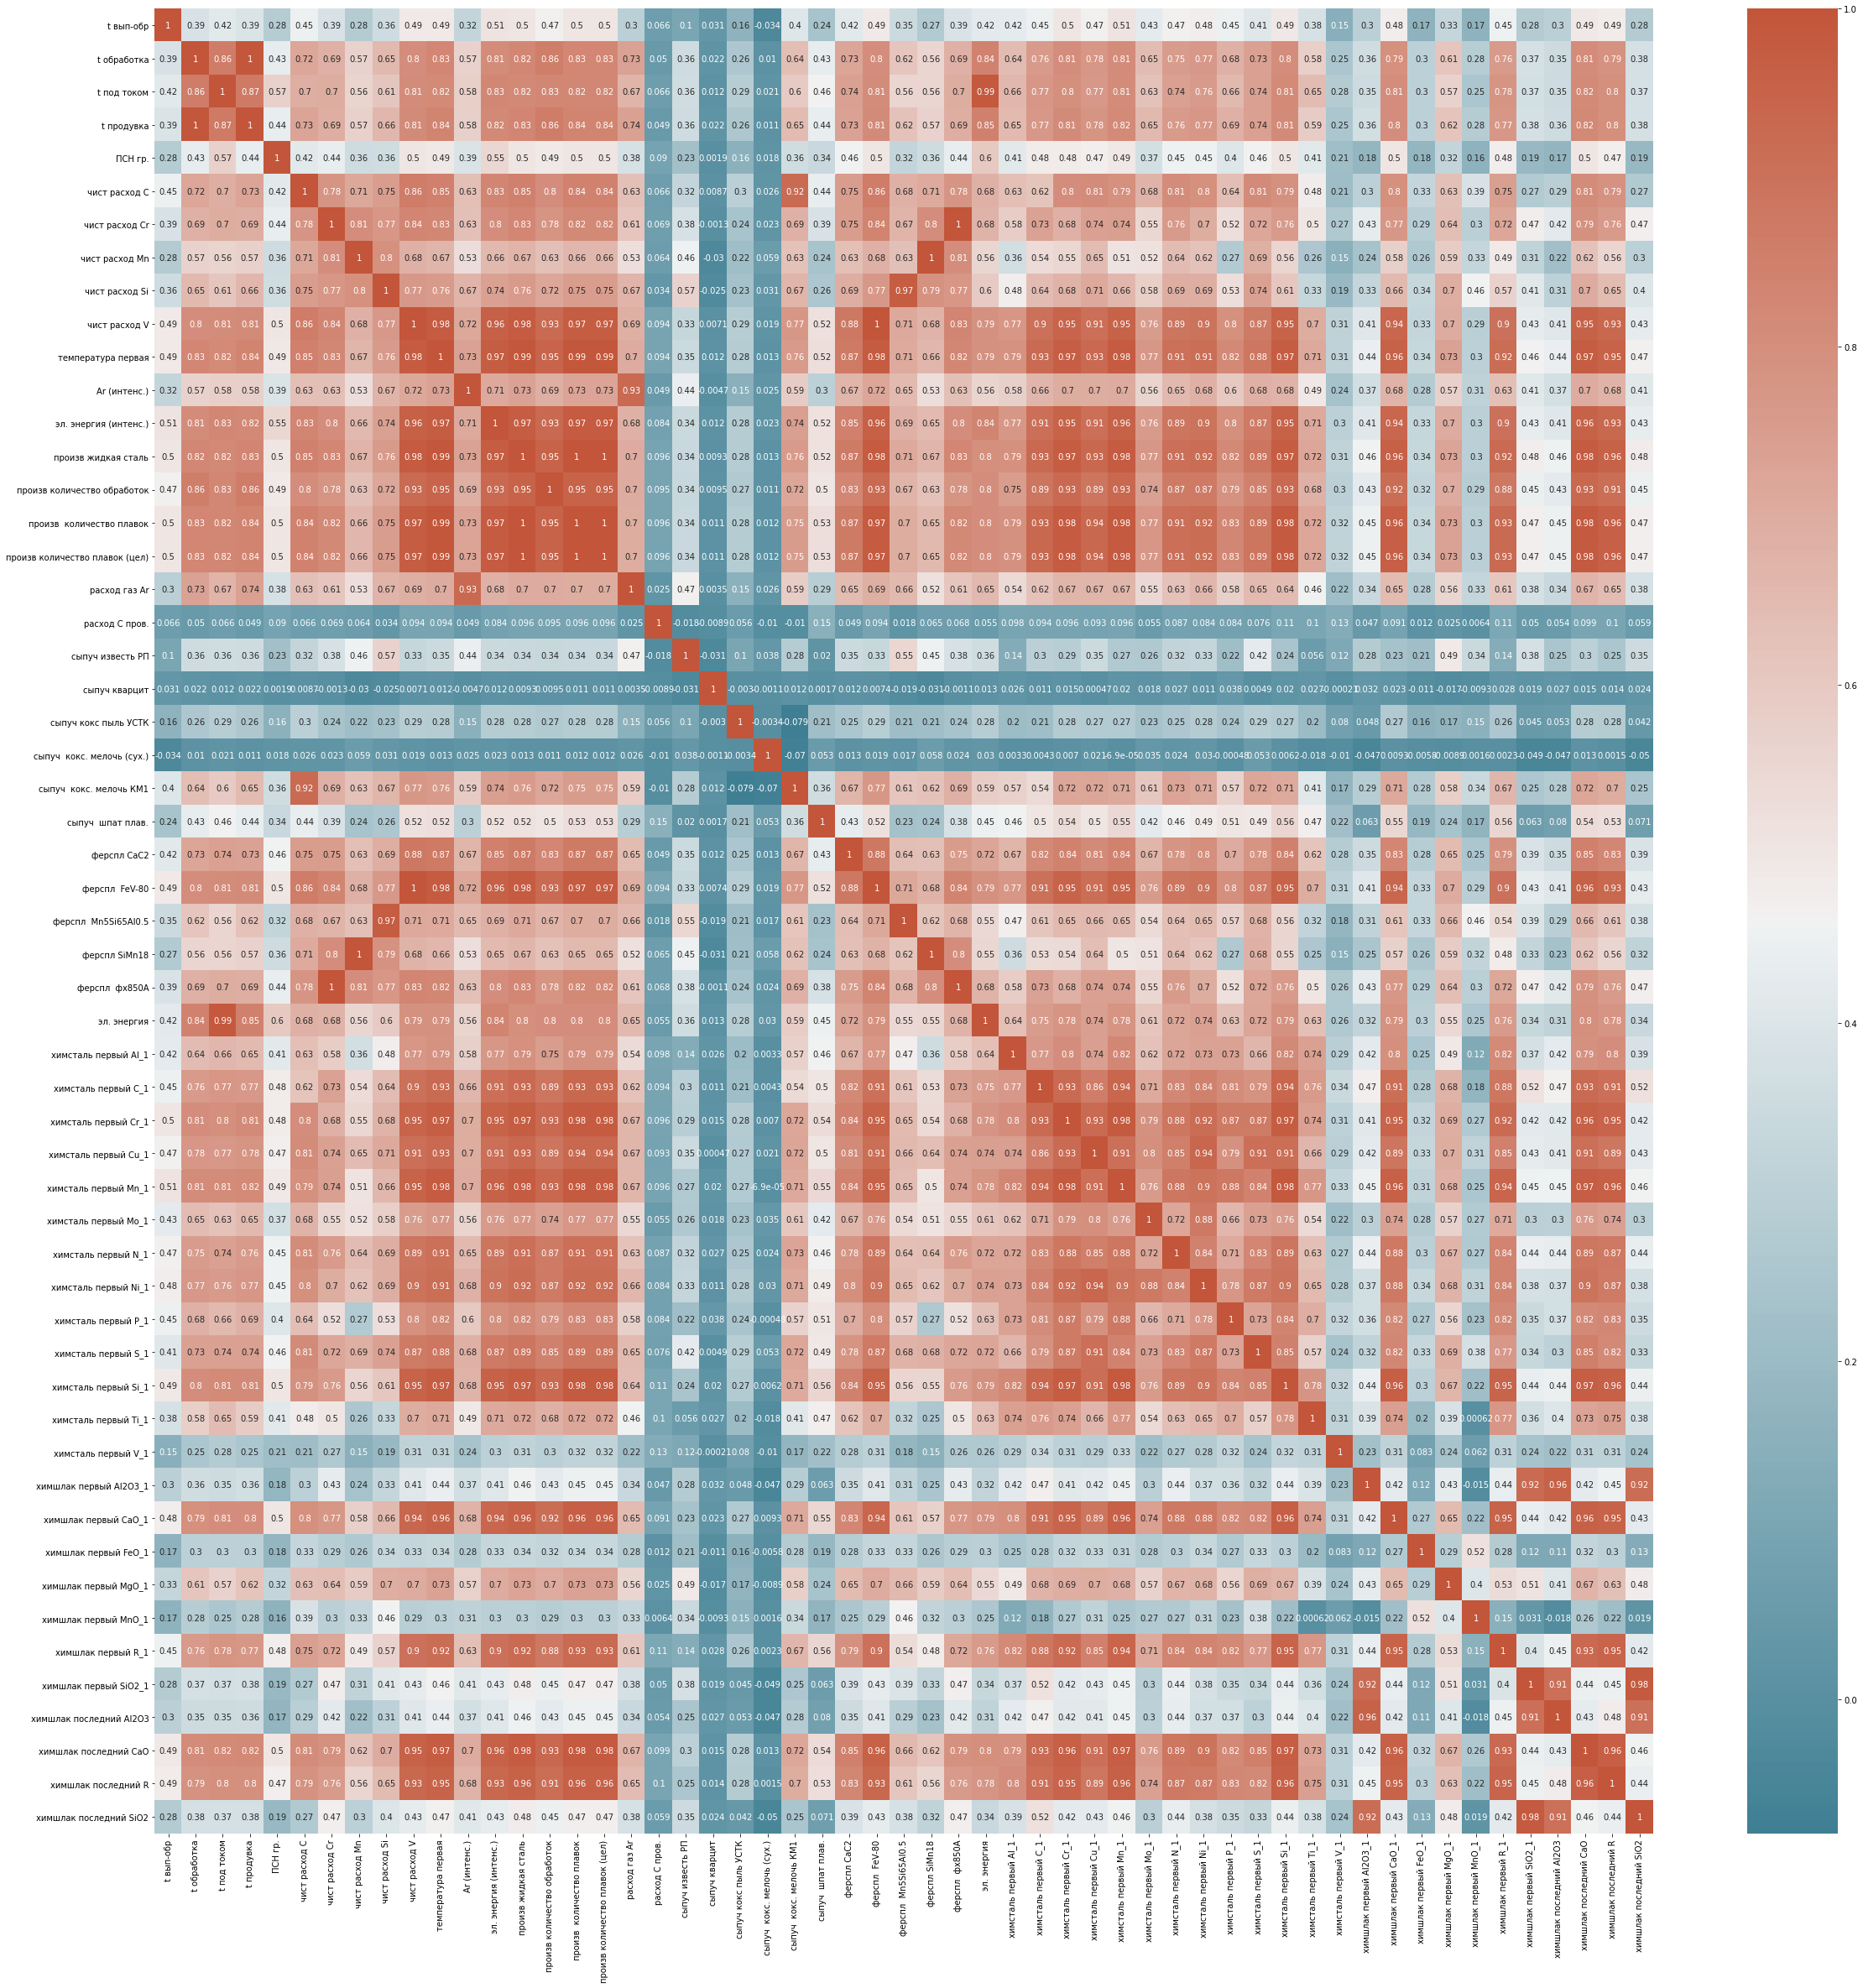

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40,40))
corr = dataset_mark.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)

# Видим во многих местах корреляцию с целевыми переменными, значит и модель сможет легко их найти

## Detect otliers

In [21]:
z = np.abs(stats.zscore(dataset_mark))
threshold = 3
dataset_mark_cleaned = dataset_mark[(z < threshold).all(axis=1)]
outliers_amount =  len(dataset_mark) - len(dataset_mark_cleaned)
print(f"Delete examples => {outliers_amount} ~ {outliers_amount / len(dataset_mark_cleaned):3f}%")

Delete examples => 614 ~ 0.141507%


## Variance

In [22]:
pd.DataFrame(dataset_mark_cleaned.var().values, index=dataset_mark_cleaned.var().index).T

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
0,248.401159,232.976768,57.871147,231.513631,2.204588,0.019513,0.002282,0.0038,0.002973,0.000172,261431.549104,22.402504,1.839417e+07,1390.593018,0.10568,0.10568,0.10568,49.8772,0.000015,0.005815,0.0,0.000557,0.0,0.022818,0.000778,0.000049,0.000272,0.004216,0.009171,0.00715,2.867720e+06,5.236375e-07,0.026621,0.010801,0.001241,0.049215,0.000008,0.000012,0.00061,0.000012,0.00005,0.022089,5.688429e-07,0.000001,4.17344,337.136892,0.145246,23.382942,0.015912,0.697662,120.166994,5.184057,350.367677,0.635167,133.207554


## В некоторых колонках мы можем наблюдать большой variance, что свидетельствует о сильной неравномерности данных

In [23]:
dataset_mark_cleaned

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
0,29.0,45.366667,24.400000,41.033333,0.000000,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,13.606742,12809.016393,115.5,1.0,1.0,1.0,18.611,0.0,0.000,0.0,0.17,0.0,0.401,0.123,0.02,0.051939,0.112,0.182,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.0,63.7,1.1,3.7,0.12,2.6,0.0,0.0,53.4,2.6,0.0
2,24.0,43.350000,17.950000,43.350000,0.000000,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,13.801968,12511.420613,115.8,1.0,1.0,1.0,19.871,0.0,0.000,0.0,0.05,0.0,0.346,0.061,0.02,0.052807,0.160,0.204,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.0,58.0,0.8,8.6,0.12,2.6,0.0,0.0,57.2,2.3,0.0
3,17.0,46.183333,19.816667,46.183333,0.000000,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,12.664958,12998.149706,116.3,1.0,1.0,1.0,19.497,0.0,0.077,0.0,0.05,0.0,0.390,0.059,0.02,0.053349,0.161,0.345,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.0,59.8,0.4,6.4,0.11,2.4,0.0,0.0,60.3,2.6,0.0
4,20.0,48.500000,17.033333,48.500000,0.000000,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,10.298350,12987.475538,115.0,1.0,1.0,1.0,16.649,0.0,0.082,0.0,0.05,0.0,0.412,0.035,0.02,0.051975,0.149,0.263,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.0,59.6,0.7,4.7,0.12,2.4,0.0,0.0,60.3,2.5,0.0
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.000,0.00,0.000000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,33.0,42.200000,17.850000,42.200000,4.000000,0.471755,0.137332,0.139956,0.176122,0.041047,1586.0,13.672038,13472.268908,115.4,1.0,1.0,1.0,19.232,0.0,0.199,0.0,0.05,0.0,0.508,0.039,0.02,0.051360,0.214,0.214,0.247,4008.0,0.002,0.405,0.300,0.112,0.661,0.009,0.010,0.082,0.007,0.020,0.423,0.001,0.003,4.3,53.9,0.8,12.6,0.63,2.1,25.2,6.6,56.1,2.3,24.6
7023,34.0,42.050000,18.533333,42.050000,2.689759,0.465055,0.112868,0.096618,0.140631,0.040180,1579.0,14.320095,12910.791367,117.4,1.0,1.0,1.0,20.072,0.0,0.000,0.0,0.05,0.0,0.506,0.049,0.02,0.050275,0.177,0.147,0.203,3988.0,0.002,0.435,0.324,0.117,0.704,0.010,0.010,0.084,0.010,0.021,0.439,0.002,0.003,3.9,50.0,0.2,9.0,0.20,2.5,20.4,5.0,57.5,2.5,23.4
7024,13.0,47.850000,20.750000,47.850000,3.000000,0.470500,0.153456,0.174962,0.130023,0.039660,1578.0,10.561526,13200.000000,116.8,1.0,1.0,1.0,16.608,0.0,0.128,0.0,0.05,0.0,0.502,0.060,0.02,0.049624,0.129,0.271,0.276,4565.0,0.002,0.403,0.287,0.128,0.641,0.009,0.010,0.089,0.007,0.024,0.461,0.002,0.003,4.8,54.1,0.7,9.9,0.13,2.4,22.4,6.2,58.0,2.3,25

# Let's make some predictions :)

In [24]:
class Experiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           target_columns = target_columns,
           folds_amount = 10,
           model = xgb.XGBRegressor(
                objective ='reg:squarederror', 
                max_depth = 5, 
              ),
           metric = None,
           model_name=None,
           metric_name="MSE"
           ):
    self.dataset = dataset
    self.target_column = target_column
    self.target_columns = target_columns
    # model
    self.model = model
    
    # metric
    self.metric = metric
    self.metric_name = metric_name

    # transform data
    self.data_transformer = StandardScaler()

    # cross validation
    self.dataset_features = self.dataset.drop(self.target_columns, axis=1)
    self.dataset_targets = self.dataset[self.target_column]
    self.folds_amount = folds_amount

  def experiment(self):
    self.model = make_pipeline(self.data_transformer, self.model)
    train_result = cross_validate(self.model, self.dataset_features, self.dataset_targets, cv=self.folds_amount, 
              scoring={self.metric_name: self.metric}, n_jobs=-1)
    
    metric_result = train_result[f'test_{self.metric_name}'].mean()

    return metric_result


class MetaExperiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           target_columns = target_columns,
           folds_amount = 10,
           model = xgb.XGBRegressor(
                objective ='reg:squarederror', 
                max_depth = 5, 
              ),
           model_name=None,
           metrics = {
               'MSE': make_scorer(mean_squared_error),
               'R2': make_scorer(r2_score),
               'MAE': make_scorer(mean_absolute_error),
               'MAPe': make_scorer(mape_vectorized_v2) 
            }
              ):
    self.dataset = dataset
    self.target_column = target_column
    self.target_columns = target_columns
    # model
    self.model = model
    self.model_name = model_name
    self.metrics = metrics

    self.folds_amount = folds_amount
    self.metrics_result = {}

  def meta_experiment(self):
    general_params = {
        'dataset': self.dataset,
        'target_column': self.target_column,
        'target_columns': self.target_columns,
        'folds_amount': self.folds_amount,
        'model': self.model,
        'model_name': self.model_name,
    }
    MSE = Experiment(
        **general_params,
        metric = self.metrics['MSE'],
        metric_name = 'MSE'
    ).experiment()
    R2 = Experiment(
        **general_params,
        metric = self.metrics['R2'],
        metric_name = 'R2'
    ).experiment()
    MAE = Experiment(
        **general_params,
        metric = self.metrics['MAE'],
        metric_name = 'MAE'
    ).experiment()
    MAPe = Experiment(
        **general_params,
        metric = self.metrics['MAPe'],
        metric_name = 'MAPe'
    ).experiment()

    print(f"Experiment for '{self.target_column}' column; Model_name => {self.model_name}")
    print(f'Mean MSE => {MSE} Mean R2 => {R2} Mean MAE => {MAE} Mean MAPe => {MAPe}')
    self.metrics_result = {'Column': self.target_column, "Model Name": self.model_name, 'R2': R2, 'MAE': MAE, 'MSE': MSE, 'MAPe': MAPe, }
    return self.metrics_result

# XGBRegressor

In [25]:
exp_1__xgb = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
    model_name='XGBRegressor'
)
exp_2__xgb = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
    model_name='XGBRegressor'
)
exp_3__xgb = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
    model_name='XGBRegressor'
)
exp_4__xgb = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
    model_name='XGBRegressor'
)
exp_1__xgb_result = exp_1__xgb.meta_experiment()
exp_2__xgb_result = exp_2__xgb.meta_experiment()
exp_3__xgb_result = exp_3__xgb.meta_experiment()
exp_4__xgb_result = exp_4__xgb.meta_experiment()

Experiment for 'химшлак последний SiO2' column; Model_name => XGBRegressor
Mean MSE => 2.75207276866623 Mean R2 => 0.8549573607844637 Mean MAE => 1.1334926803914729 Mean MAPe => 0.06840203248351692


In [26]:
PREDICTIONS_ARRAY[target_col_1].append(exp_1__xgb_result)
PREDICTIONS_ARRAY[target_col_2].append(exp_2__xgb_result)
PREDICTIONS_ARRAY[target_col_3].append(exp_3__xgb_result)
PREDICTIONS_ARRAY[target_col_4].append(exp_4__xgb_result)

# LGBM

In [27]:
hyper_params = {
    # 'task': 'train',
    # 'boosting_type': 'gbdt',
    # 'objective': 'regression',
    # 'metric': ['l2', 'mse'],
    # 'learning_rate': 0.005,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.7,
    # 'bagging_freq': 10,
    # 'verbose': 0,
    # "max_depth": 8,
    # "num_leaves": 128,  
    # "max_bin": 512,
    # "num_iterations": 1000,
    # "n_estimators": 1000
}

exp_1__LGBM = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
    model=lgb.LGBMRegressor(**hyper_params),
    model_name='LGBMRegressor'
)
exp_2__LGBM = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
    model=lgb.LGBMRegressor(**hyper_params),
    model_name='LGBMRegressor'
)
exp_3__LGBM = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
    model=lgb.LGBMRegressor(**hyper_params),
    model_name='LGBMRegressor'
)
exp_4__LGBM = MetaExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
    model=lgb.LGBMRegressor(**hyper_params),
    model_name='LGBMRegressor'
)

exp_1__LGBM_result =  exp_1__LGBM.meta_experiment()
exp_2__LGBM_result =  exp_2__LGBM.meta_experiment()
exp_3__LGBM_result =  exp_3__LGBM.meta_experiment()
exp_4__LGBM_result =  exp_4__LGBM.meta_experiment()

Experiment for 'химшлак последний SiO2' column; Model_name => LGBMRegressor
Mean MSE => 2.784321408417512 Mean R2 => 0.8541142869455763 Mean MAE => 1.1272259856614828 Mean MAPe => 0.06660876609775038


In [28]:
# PREDICTIONS_ARRAY[target_col_1].append(exp_1__LGBM_result)
# PREDICTIONS_ARRAY[target_col_2].append(exp_2__LGBM_result)
# PREDICTIONS_ARRAY[target_col_3].append(exp_3__LGBM_result)
PREDICTIONS_ARRAY[target_col_4].append(exp_4__LGBM_result)

# TabNet

In [29]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# metrics
class pytorch_R2(Metric):
  def __init__(self):
    self._name = "R2"
    self._maximize = True
  def __call__(self, y_true, y_pred):
    return r2_score(y_true, y_pred)

class pytorch_MAPe(Metric):
  def __init__(self):
    self._name = "MAPe"
    self._maximize = False
  def __call__(self, y_true, y_pred):
    return mape_vectorized_v2(y_true, y_pred)

class pytorch_MSE(Metric):
  def __init__(self):
    self._name = "MSE"
    self._maximize = False
  def __call__(self, y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

class pytorch_MAE(Metric):
  def __init__(self):
    self._name = "MAE"
    self._maximize = False
  def __call__(self, y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

class TabNetExperiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           target_columns = target_columns,
           folds_amount = 10,
           metric = None,
           metric_name = None
           ):
    self.dataset = dataset
    self.target_column = target_column
    self.target_columns = target_columns
    # model
    self.model = TabNetRegressor(verbose=0, seed=42),
    self.model_name = "TabNet"
    self.metric = metric
    self.metric_name = metric_name

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # transform data
    self.data_transformer = StandardScaler()
    self.seed = 42

    # cross validation
    self.dataset_features = self.dataset.drop(self.target_columns, axis=1).to_numpy()
    self.dataset_targets = self.dataset[self.target_column].to_numpy().reshape(-1, 1)
    self.folds_amount = folds_amount
    self.k_fold = KFold(n_splits=self.folds_amount, random_state=self.seed, shuffle=True)

  def experiment(self, epochs=2000, patience=200):
    
    CV_score_array = []

    model = None
    
    for train_index, test_index in self.k_fold.split(self.dataset_features):
      
      X_train, X_valid = self.dataset_features[train_index], self.dataset_features[test_index]
      y_train, y_valid = self.dataset_targets[train_index], self.dataset_targets[test_index]

      x_scaler = StandardScaler()
      X_train = x_scaler.fit_transform(X_train)
      X_valid = x_scaler.transform(X_valid)
      
      model = TabNetRegressor(verbose=20, 
                              seed=self.seed,
                              device_name=self.device
                              )
      model.fit(X_train=X_train, 
                y_train=y_train,
                eval_set=[(X_valid, y_valid)],
                patience=patience, max_epochs=epochs,
                eval_name=['val'],
                eval_metric=[self.metric])
      
      CV_score_array.append(model.best_cost)
    
    best_metric = np.mean(CV_score_array, axis=0)
    return best_metric

class MetaTabNetExperiment:
  def __init__(self, 
           dataset = None,
           target_column = None,
           target_columns = target_columns,
           folds_amount = 10,
           model_name='TabNet',
           metrics = {
               'MSE': pytorch_MSE,
               'R2': pytorch_R2,
               'MAE': pytorch_MAE,
               'MAPe': pytorch_MAPe 
            }
              ):
    self.dataset = dataset
    self.target_column = target_column
    self.target_columns = target_columns
    # model
    self.metrics = metrics
    self.model_name = model_name

    self.folds_amount = folds_amount
    self.metrics_result = {}

  def meta_experiment(self):
    general_params = {
        'dataset': self.dataset,
        'target_column': self.target_column,
        'target_columns': self.target_columns,
        'folds_amount': self.folds_amount,
    }
    R2 = TabNetExperiment(
        **general_params,
        metric = self.metrics['R2'],
        metric_name = 'R2'
    ).experiment()
    MSE = TabNetExperiment(
        **general_params,
        metric = self.metrics['MSE'],
        metric_name = 'MSE'
    ).experiment()
    MAE = TabNetExperiment(
        **general_params,
        metric = self.metrics['MAE'],
        metric_name = 'MAE'
    ).experiment()
    MAPe = TabNetExperiment(
        **general_params,
        metric = self.metrics['MAPe'],
        metric_name = 'MAPe'
    ).experiment()

    print(f"Experiment for '{self.target_column}' column; Model_name => {self.model_name}")
    print(f'Mean MSE => {MSE} Mean R2 => {R2} Mean MAE => {MAE} Mean MAPe => {MAPe}')
    self.metrics_result = {'Column': self.target_column, "Model Name": self.model_name, 'R2': R2, 'MAE': MAE, 'MSE': MSE, 'MAPe': MAPe, }
    return self.metrics_result

In [ ]:
tabnet_1 = MetaTabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_1,
)
tabnet_1_result = tabnet_1.meta_experiment()

In [ ]:
tabnet_2 = MetaTabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_2,
)
tabnet_2_result = tabnet_2.meta_experiment()

In [ ]:
tabnet_3 = MetaTabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_3,
)
tabnet_3_result = tabnet_3.meta_experiment()

In [30]:
tabnet_4 = MetaTabNetExperiment(
    dataset=dataset_mark_cleaned,
    target_column=target_col_4,
)
tabnet_4_result = tabnet_4.meta_experiment()

Device used : cuda
epoch 0  | loss: 379.09282| val_R2: -1.32478|  0:00:00s
epoch 20 | loss: 2.93255 | val_R2: 0.98085 |  0:00:03s
epoch 40 | loss: 2.54015 | val_R2: 0.94775 |  0:00:06s
epoch 60 | loss: 2.36541 | val_R2: 0.98177 |  0:00:09s
epoch 80 | loss: 2.26285 | val_R2: 0.98199 |  0:00:13s
epoch 100| loss: 2.34888 | val_R2: 0.97961 |  0:00:16s
epoch 120| loss: 1.93594 | val_R2: 0.98044 |  0:00:19s
epoch 140| loss: 1.77863 | val_R2: 0.97931 |  0:00:22s
epoch 160| loss: 1.63937 | val_R2: 0.97938 |  0:00:25s
epoch 180| loss: 1.73275 | val_R2: 0.97789 |  0:00:28s
epoch 200| loss: 1.40785 | val_R2: 0.97589 |  0:00:32s
epoch 220| loss: 1.28708 | val_R2: 0.97814 |  0:00:35s
epoch 240| loss: 1.26449 | val_R2: 0.97648 |  0:00:38s
epoch 260| loss: 1.41413 | val_R2: 0.97744 |  0:00:41s

Early stopping occurred at epoch 264 with best_epoch = 64 and best_val_R2 = 0.9824
Best weights from best epoch are automatically used!
Device used : cuda
epoch 0  | loss: 374.57714| val_R2: -1.86897|  0:00:00

In [31]:
PREDICTIONS_ARRAY[target_col_1].append(tabnet_1_result)
PREDICTIONS_ARRAY[target_col_2].append(tabnet_2_result)
PREDICTIONS_ARRAY[target_col_3].append(tabnet_3_result)
PREDICTIONS_ARRAY[target_col_4].append(tabnet_4_result)

# Metrics result

In [36]:
metrics_dataset_1 = pd.DataFrame(columns=['Column',"Model Name", 'R2', 'MAE', 'MSE', 'MAPe'])
metrics_dataset_2 = pd.DataFrame(columns=['Column',"Model Name", 'R2', 'MAE', 'MSE', 'MAPe'])
metrics_dataset_3 = pd.DataFrame(columns=['Column',"Model Name", 'R2', 'MAE', 'MSE', 'MAPe'])


In [32]:
metrics_dataset_4 = pd.DataFrame(columns=['Column',"Model Name", 'R2', 'MAE', 'MSE', 'MAPe'])

# химшлак последний Al2O3

In [37]:
for item in PREDICTIONS_ARRAY[target_col_1]:
  # print(item)
  metrics_dataset_1 = metrics_dataset_1.append(item, ignore_index=True)
metrics_dataset_1

,Column,Model Name,R2,MAE,MSE,MAPe
0,химшлак последний Al2O3,XGBRegressor,0.739275,0.338354,0.307893,0.098108
1,химшлак последний Al2O3,LGBMRegressor,0.747387,0.341773,0.314094,0.102445
2,химшлак последний Al2O3,TabNet,0.943267,0.327076,0.292709,0.105351


# химшлак последний CaO

In [38]:
for item in PREDICTIONS_ARRAY[target_col_2]:
  # print(item)
  metrics_dataset_2 = metrics_dataset_2.append(item, ignore_index=True)
metrics_dataset_2

,Column,Model Name,R2,MAE,MSE,MAPe
0,химшлак последний CaO,XGBRegressor,0.895744,2.413937,10.676451,0.049618
1,химшлак последний CaO,LGBMRegressor,0.895750,2.400903,10.704460,0.049251
2,химшлак последний CaO,TabNet,0.971344,2.282357,9.952410,0.047143


# химшлак последний R

In [39]:
for item in PREDICTIONS_ARRAY[target_col_3]:
  # print(item)
  metrics_dataset_3 = metrics_dataset_3.append(item, ignore_index=True)
metrics_dataset_3

,Column,Model Name,R2,MAE,MSE,MAPe
0,химшлак последний R,XGBRegressor,0.855428,0.127898,0.028758,0.060853
1,химшлак последний R,LGBMRegressor,0.855177,0.128024,0.029141,0.060880
2,химшлак последний R,TabNet,0.956060,0.125069,0.027699,0.058753


# химшлак последний SiO2

In [33]:
for item in PREDICTIONS_ARRAY[target_col_4]:
  # print(item)
  metrics_dataset_4 = metrics_dataset_4.append(item, ignore_index=True)
metrics_dataset_4

,Column,Model Name,R2,MAE,MSE,MAPe
0,химшлак последний SiO2,XGBRegressor,0.854957,1.133493,2.752073,0.068402
1,химшлак последний SiO2,LGBMRegressor,0.854114,1.127226,2.784321,0.066609
2,химшлак последний SiO2,TabNet,0.980732,1.061235,2.555623,0.068341


### Как видно по следующим значениям TabNet обходит стандартные параметры XGBRegressor и LGBMRegressor, особенно хорошо показывает себя XGBRegressor. В большинстве случаев разница в десятых или даже сотых, но с ним есть многократная выгода в скорости тренировки и инференса.

# Experiments with data

In [40]:
dataset_mark_cleaned[dataset_mark_cleaned[target_columns[0]] != 0]

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
589,18.0,42.016667,20.016667,41.850000,2.431057,0.339285,0.075060,0.066049,0.068946,0.038742,1577.0,8.060323,12550.541216,110.8,1.0,1.0,1.0,11.224,0.0,0.000,0.0,0.05,0.0,0.359,0.126,0.02,0.048647,0.079,0.101,0.135,4187.0,0.001,0.525,0.350,0.119,0.740,0.008,0.008,0.080,0.011,0.024,0.519,0.002,0.003,2.7,58.6,0.3,13.1,0.23,2.3,25.6,3.2,54.8,2.4,23.2
1345,26.0,42.050000,19.883333,42.050000,3.775293,0.402655,0.168487,0.176548,0.153988,0.041933,1565.0,18.348157,13609.388097,116.9,1.0,1.0,1.0,25.718,0.0,0.000,0.0,0.05,0.0,0.417,0.039,0.02,0.052879,0.164,0.266,0.289,4510.0,0.002,0.452,0.280,0.096,0.642,0.006,0.009,0.065,0.007,0.018,0.434,0.002,0.002,5.3,48.8,0.7,14.2,0.19,2.2,22.4,5.2,54.5,2.1,26.6
1348,16.0,48.183333,20.483333,48.183333,3.667811,0.399455,0.130009,0.123483,0.152815,0.038794,1582.0,11.140541,12923.677787,112.8,1.0,1.0,1.0,17.862,0.0,0.000,0.0,0.05,0.0,0.422,0.074,0.02,0.048828,0.185,0.184,0.223,4412.0,0.001,0.455,0.312,0.111,0.693,0.007,0.010,0.068,0.010,0.018,0.426,0.001,0.002,4.4,53.3,0.4,10.9,0.19,2.2,24.6,4.4,55.6,2.1,26.9
1662,7.0,47.016667,23.166667,47.016667,2.776518,0.421980,0.116688,0.118367,0.130000,0.038807,1604.0,14.371775,12519.712230,111.7,1.0,1.0,1.0,22.404,0.0,0.122,0.0,0.05,0.0,0.452,0.038,0.02,0.048539,0.155,0.176,0.204,4834.0,0.002,0.418,0.319,0.091,0.692,0.006,0.010,0.063,0.011,0.017,0.457,0.001,0.002,5.2,56.2,0.7,11.7,0.14,2.7,20.6,4.5,55.8,2.0,27.4
1663,12.0,49.383333,32.166667,49.383333,3.626010,0.404285,0.116116,0.150958,0.129965,0.038460,1536.0,6.976905,12780.932642,113.7,1.0,1.0,1.0,11.446,0.0,0.082,0.0,0.05,0.0,0.429,0.048,0.02,0.048105,0.141,0.227,0.203,6852.0,0.002,0.452,0.318,0.114,0.666,0.007,0.011,0.073,0.009,0.019,0.451,0.002,0.002,5.0,53.8,1.4,10.1,0.20,2.3,23.1,4.8,55.0,2.0,27.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,33.0,42.200000,17.850000,42.200000,4.000000,0.471755,0.137332,0.139956,0.176122,0.041047,1586.0,13.672038,13472.268908,115.4,1.0,1.0,1.0,19.232,0.0,0.199,0.0,0.05,0.0,0.508,0.039,0.02,0.051360,0.214,0.214,0.247,4008.0,0.002,0.405,0.300,0.112,0.661,0.009,0.010,0.082,0.007,0.020,0.423,0.001,0.003,4.3,53.9,0.8,12.6,0.63,2.1,25.2,6.6,56.1,2.3,24.6
7023,34.0,42.050000,18.533333,42.050000,2.689759,0.465055,0.112868,0.096618,0.140631,0.040180,1579.0,14.320095,12910.791367,117.4,1.0,1.0,1.0,20.072,0.0,0.000,0.0,0.05,0.0,0.506,0.049,0.02,0.050275,0.177,0.147,0.203,3988.0,0.002,0.435,0.324,0.117,0.704,0.010,0.010,0.084,0.010,0.021,0.439,0.002,0.003,3.9,50.0,0.2,9.0,0.20,2.5,20.4,5.0,57.5,2.5,23.4
7024,13.0,47.850000,20.750000,47.850000,3.000000,0.470500,0.153456,0.174962,0.130023,0.039660,1578.0,10.561526,13200.000000,116.8,1.0,1.0,1.0,16.608,0.0,0.128,0.0,0.05,0.0,0.502,0.060,0.02,0.049624,0.129,0.271,0.276,4565.0,0.002,0.403,0.287,0.128,0.641,0.009,0.010,0.089,0.007,0.024,0.461,0.002,0.003,

In [43]:
exp_1__xgb_without_zero = MetaExperiment(
    dataset=dataset_mark_cleaned[dataset_mark_cleaned[target_col_1] != 0],
    target_column=target_col_1,
    model_name='XGBRegressor'
)

exp_1__xgb_without_zero_result = exp_1__xgb_without_zero.meta_experiment()

Experiment for 'химшлак последний Al2O3' column; Model_name => XGBRegressor
Mean MSE => 0.4705175898643475 Mean R2 => 0.36846388402535596 Mean MAE => 0.49661615141162113 Mean MAPe => 0.11139333886629596


In [44]:
len(dataset_mark_cleaned[dataset_mark_cleaned[target_col_1] != 0])

2846

In [45]:
tabnet_1_without_zero = MetaTabNetExperiment(
    dataset=dataset_mark_cleaned[dataset_mark_cleaned[target_col_1] != 0],
    target_column=target_col_1,
)
tabnet_1_without_zero_result = tabnet_1_without_zero.meta_experiment()

Device used : cuda
epoch 0  | loss: 22.29356| val_R2: -19.20112|  0:00:00s
epoch 20 | loss: 0.57332 | val_R2: 0.2482  |  0:00:02s
epoch 40 | loss: 0.44885 | val_R2: 0.37516 |  0:00:04s
epoch 60 | loss: 0.42017 | val_R2: 0.40343 |  0:00:07s
epoch 80 | loss: 0.40805 | val_R2: 0.42618 |  0:00:09s
epoch 100| loss: 0.39113 | val_R2: 0.43303 |  0:00:11s
epoch 120| loss: 0.37213 | val_R2: 0.38924 |  0:00:14s
epoch 140| loss: 0.35173 | val_R2: 0.43468 |  0:00:16s
epoch 160| loss: 0.35365 | val_R2: 0.41242 |  0:00:19s
epoch 180| loss: 0.31669 | val_R2: 0.37527 |  0:00:21s
epoch 200| loss: 0.3163  | val_R2: 0.42292 |  0:00:23s
epoch 220| loss: 0.29439 | val_R2: 0.38129 |  0:00:25s
epoch 240| loss: 0.28529 | val_R2: 0.35601 |  0:00:28s
epoch 260| loss: 0.26288 | val_R2: 0.38858 |  0:00:30s
epoch 280| loss: 0.273   | val_R2: 0.37684 |  0:00:32s
epoch 300| loss: 0.25504 | val_R2: 0.4162  |  0:00:35s
epoch 320| loss: 0.22543 | val_R2: 0.36646 |  0:00:37s

Early stopping occurred at epoch 325 with be